Summary of Analysis:
1. Age, heart rate, blood pressure, and cholestorol levels were used to classify people into smokers and non-smokers
2. After tuning a random forest model, predictions were made with above 60% accuracy, ok but not great
3. This probably means that although cholestorol blood pressure, heart rate, and age contribute to the model, they do not paint the whole picture. For example, someone may have high cholestorol for reasons apart from smoking, and therefore it is not 

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [63]:
smoking = pd.read_csv('smoking_health_data_final.csv')

In [64]:
smoking.head()

,age,sex,current_smoker,heart_rate,blood_pressure,cigs_per_day,chol
0,54,male,yes,95,110/72,NaN,219.0
1,45,male,yes,64,121/72,NaN,248.0
2,58,male,yes,81,127.5/76,NaN,235.0
3,42,male,yes,90,122.5/80,NaN,225.0
4,42,male,yes,62,119/80,NaN,226.0


In [65]:
smoking.describe()

,age,heart_rate,cigs_per_day,chol
count,3900.000000,3900.000000,3886.000000,3893.000000
mean,49.537949,75.688974,9.168554,236.595941
std,8.559275,12.015376,12.037999,44.375365
min,32.000000,44.000000,0.000000,113.000000
25%,42.000000,68.000000,0.000000,206.000000
50%,49.000000,75.000000,0.000000,234.000000
75%,56.000000,82.000000,20.000000,263.000000
max,70.000000,143.000000,70.000000,696.000000


In [85]:
smoking['current_smoker'].value_counts()

0    1965
1    1914
Name: current_smoker, dtype: int64

In [66]:
# Assuming 'blood_pressure' column contains strings like "110/72"
smoking[['systolic', 'diastolic']] = smoking['blood_pressure'].str.split('/', expand=True).astype(float)

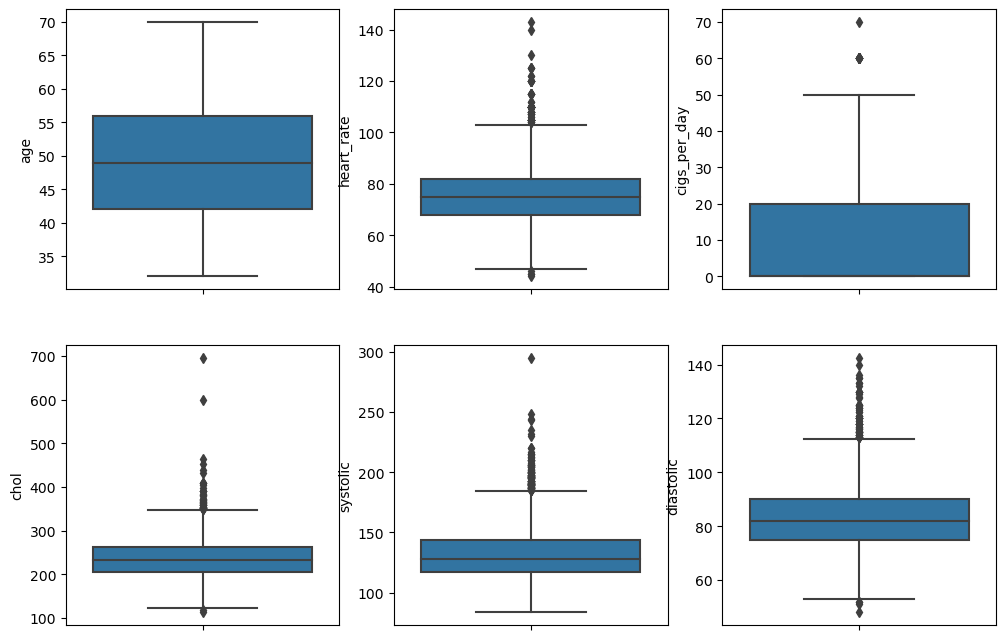

In [67]:
numerical_columns = ['age','heart_rate','cigs_per_day','chol','systolic','diastolic']
# Create boxplots for each continuous variable
plt.figure(figsize=(12, 8))
for i, var in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Create a grid of subplots
    sns.boxplot(data=smoking,y=var)
plt.show()

In [68]:
# Calculate the correlation matrix for continuous variables
correlation_matrix = smoking.corr()

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_57078/2762427200.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = smoking.corr()


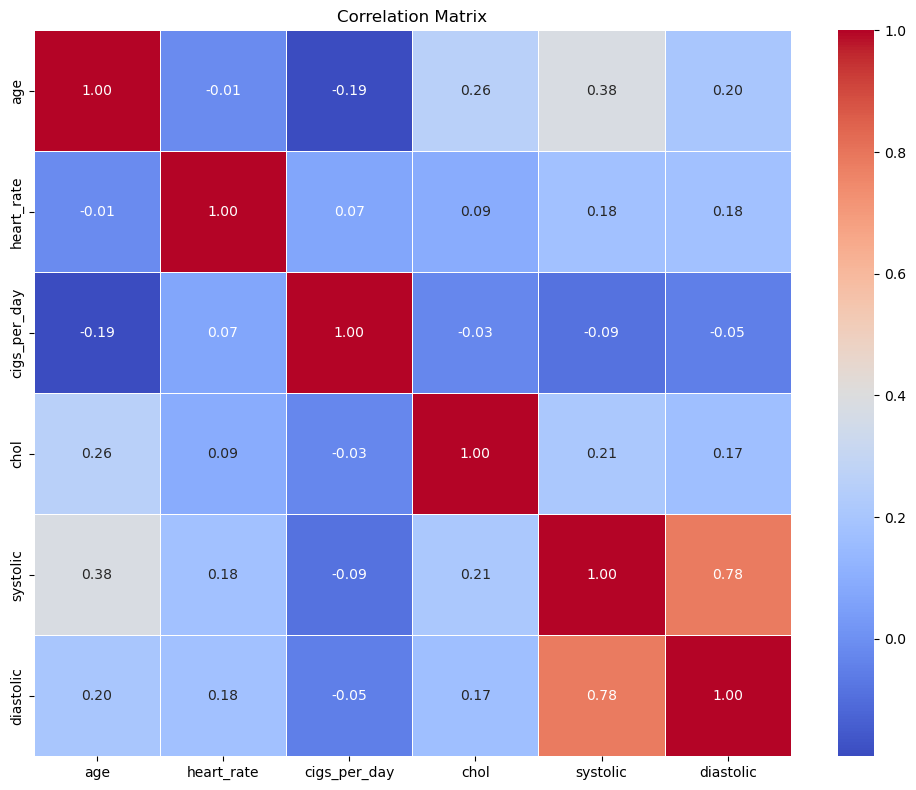

In [69]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and show the plot
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [70]:
#Classification
# For binary features like sex (assuming 'male'/'female') and current_smoker ('yes'/'no')
smoking_mapped = smoking
smoking_mapped['sex'] = smoking['sex'].map({'male': 1, 'female': 0})
smoking_mapped['current_smoker'] = smoking['current_smoker'].map({'yes': 1, 'no': 0})

In [73]:
smoking_mapped.drop('cigs_per_day',axis=1,inplace=True)
smoking_mapped.dropna(inplace=True)
smoking_mapped.head()

,age,sex,current_smoker,heart_rate,chol,systolic
14,48,1,0,75,175.0,131.0
15,58,0,0,75,240.0,126.0
16,46,0,0,80,199.0,102.0
17,45,0,0,75,235.0,106.0
18,37,0,0,81,300.0,112.0


In [75]:
X = smoking_mapped.drop('current_smoker', axis=1)
y = smoking_mapped['current_smoker']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
#Try logistic regression
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform training data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
# Initialize and fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # max_iter for convergence
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [91]:
# Predict on the test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6224226804123711
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64       415
           1       0.59      0.62      0.60       361

    accuracy                           0.62       776
   macro avg       0.62      0.62      0.62       776
weighted avg       0.62      0.62      0.62       776



In [92]:
# Check the coefficients (feature importance)
coefficients = log_reg.coef_[0]
feature_importance = pd.DataFrame(coefficients, index=X.columns, columns=['Coefficient'])
print(feature_importance)

            Coefficient
age           -0.420095
sex            0.466278
heart_rate     0.199976
chol           0.040587
systolic      -0.162831


In [78]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [79]:
print("Best parameters:", grid.best_params_)

Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [82]:
best_model = grid.best_estimator_

In [83]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.52      0.59       415
           1       0.56      0.70      0.62       361

    accuracy                           0.61       776
   macro avg       0.62      0.61      0.61       776
weighted avg       0.62      0.61      0.60       776

[[217 198]
 [107 254]]


In [76]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       415
           1       0.55      0.57      0.56       361

    accuracy                           0.59       776
   macro avg       0.58      0.58      0.58       776
weighted avg       0.59      0.59      0.59       776



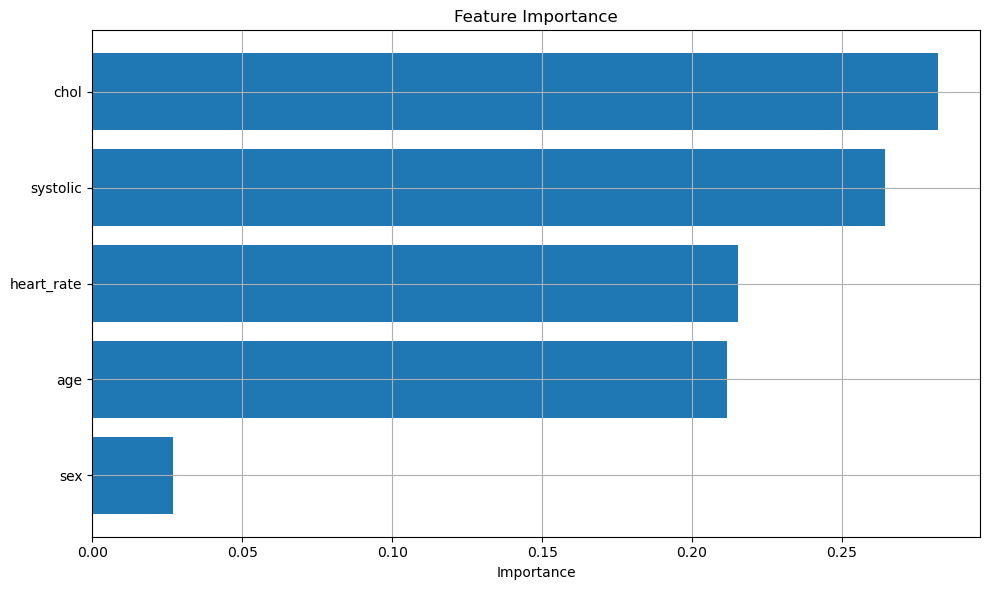

In [62]:
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()